<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [2]:
!pip install datasets

Импорт необходимых библиотек

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [6]:
# Загрузим датасет
dataset = load_dataset('imdb')

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [7]:
sentences = []
word_threshold = 32

# Получить отдельные предложения и поместить их в sentences
for text in tqdm(dataset['train']['text']):
    sentences.extend(
        [word_tokenize(sentence.lower()) for sentence in sent_tokenize(text, language='russian') if len(word_tokenize(sentence.lower())) <= word_threshold]
    )

  0%|          | 0/25000 [00:00<?, ?it/s]

In [8]:
print("Всего предложений:", len(sentences))

Всего предложений: 204649


Посчитаем для каждого слова его встречаемость.

In [9]:
words = Counter()

# Расчет встречаемости слов
for sentence in tqdm(sentences):
    for word in sentence:
        words[word] += 1

  0%|          | 0/204649 [00:00<?, ?it/s]

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [10]:
vocab = set()
vocab_size = 40000

for word, _ in words.most_common(vocab_size):
    vocab.add(word)

vocab.add('<unk>')
vocab.add('<bos>')
vocab.add('<eos>')
vocab.add('<pad>')

In [11]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [12]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [13]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [14]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in self.data[idx]
        ]
        tokenized_sentence += [self.eos_id]

        # item = {
        #     "text": tokenized_sentence,
        #     "label": self.data[idx]['label']
        # }

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [15]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [16]:
#Берем поменьше данных, чтобы быстрее можно было тестировать
train_sentences, eval_sentences = train_test_split(sentences[:40000], test_size=0.2)
# eval_sentences, test_sentences = train_test_split(test_eval_sentences, test_size=0.4)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
# test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

# test_dataloader = DataLoader(
#     test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [16]:
def evaluate(model, criterion, dataloader) -> (float, float):
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity, loss

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [17]:
import copy
DATA_MODES = ['train', 'val', 'test']

In [18]:
def train_model(model, criterion, optimizer, lr_scheduler, train_loader, val_loader, epochs=15, freeze_threshold=0.5, freeze_max_number=3, print_logs=True):
    dataloaders = {'train': train_loader, 'val': val_loader}

    losses = {'train': [], 'val': []}
    perplexities = {'train': [], 'val': []}

    best_model_wts = model.state_dict()
    best_perplexity = 100000000
    best_loss = 100000000
    num_freeze = 0

    for epoch in range(epochs):
        if print_logs:
          print('* Epoch %d/%d' % (epoch+1, epochs))
        for data_mode in DATA_MODES[:2]:
            if data_mode == 'train':
                model.train()
            else:
                model.eval()

            data_size = 0
            running_perplexity = 0
            perplexity = []

            running_loss = 0

            if data_mode == 'train':
                # for batch in tqdm(dataloaders[data_mode], desc=f'Training epoch {epoch}:'):
                for batch in dataloaders[data_mode]:
                    X = batch['input_ids'].to(device)
                    y = batch['target_ids'].to(device)
                    optimizer.zero_grad()

                    logits = model(X).flatten(start_dim=0, end_dim=1)
                    loss = criterion(logits, y.flatten())
                    loss.backward()
                    optimizer.step()

                    # running_perplexity += torch.exp(loss).item()
                    perplexity.append(torch.exp(loss).item())

                    running_loss += loss.item() * X.size(0)
                    data_size += X.size(0)

                # epoch_perplexity = running_perplexity / data_size
                epoch_perplexity = sum(perplexity) / len(perplexity)

                epoch_loss = running_loss / data_size
            else:
                epoch_perplexity, epoch_loss = evaluate(model, criterion, dataloaders['val'])

            perplexities[data_mode].append(epoch_perplexity)
            losses[data_mode].append(epoch_loss)

            if data_mode == 'train':
                lr_scheduler.step(epoch_loss)
                if print_logs:
                  print('* Train  Epoch perplexity: %f  Epoch loss: %f' % (epoch_perplexity, epoch_loss))
            else:
                if print_logs:
                  print('* Val    Epoch perplexity: %f  Epoch loss: %f' % (epoch_perplexity, epoch_loss))

            # сохраняем лучшую модель
            if data_mode == 'val' and epoch_perplexity < best_perplexity:
                best_perplexity = epoch_perplexity
                if print_logs:
                  print('Saving best model...')
                best_model_wts = copy.deepcopy(model.state_dict())

            if data_mode == 'val':
                if len(perplexities[data_mode]) > 1 and (perplexities[data_mode][-2] - perplexities[data_mode][-1] < freeze_threshold):
                    num_freeze += 1
                else:
                    num_freeze = 0

        if num_freeze == freeze_max_number:
            break

    model.load_state_dict(best_model_wts)

    if print_logs:
      print()
      print("The model is trained")

    print("Best perplexity: ", best_perplexity)
    print("perplexities: ", perplexities)
    print("losses: ", losses)
    return model, losses, perplexities

Будем использовать данный метод для генерации продолжения текста.

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

In [20]:
class LanguageModel(nn.Module):
    def __init__(
            self, hidden_dim: int,
            vocab_size: int,
            dropout_part = 0.1,
            rec_layers = 1,
            rnn_type: str = 'rnn'
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)

        if rnn_type == 'rnn':
            self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True, num_layers=rec_layers)
        elif rnn_type == 'gru':
            self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True, num_layers=rec_layers)
        else: #'lstm'
            self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers=rec_layers)

        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_part)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return prediction

In [21]:
def start_train(Model = LanguageModel, dropout_part=0.1, rec_layers=1, hidden_dim=256, epochs=5, rnn_type='rnn', freeze_threshold=0.5, freeze_max_number=3, print_logs=True):
    model = Model(hidden_dim=hidden_dim, vocab_size=len(vocab), rec_layers=rec_layers, dropout_part=dropout_part, rnn_type=rnn_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.1)
    return train_model(model, criterion, optimizer, lr_scheduler, train_dataloader, eval_dataloader, epochs=epochs, freeze_threshold=freeze_threshold, freeze_max_number=freeze_max_number, print_logs=print_logs)

Вначале найдем оптимальные параметры для vanilla_RNN и LSTM: dropout_part, rec_layers, hidden_dim. А потом уже будем немного изменять архитектуру модельки. <br>
У нас уже есть примерные представления о том, какие значения должны принимать эти параметры из предыдущего дз.
Так что будем перебирать такие значения:
dropout_part = [0.1, 0.2, 0.4]
rec_layers = [1, 2] #Особо нет смысла рассматривать большие значения из-за затухания градиентов. Возможно, только для LSTM есть.
hidden_dim = [256, 512]
rnn_type = ['rnn', 'lstm'] #Все же интереснее всего самый экономный вариант и самый мощный

In [71]:
test_perplexity = {'rnn': {}, 'lstm': {}}

test_perplexity['rnn'][0.1] = {}
test_perplexity['rnn'][0.1][1] = {}
test_perplexity['rnn'][0.1][2] = {}

test_perplexity['rnn'][0.2] = {}
test_perplexity['rnn'][0.2][1] = {}
test_perplexity['rnn'][0.2][2] = {}

test_perplexity['rnn'][0.4] = {}
test_perplexity['rnn'][0.4][1] = {}
test_perplexity['rnn'][0.4][2] = {}

test_perplexity['lstm'][0.1] = {}
test_perplexity['lstm'][0.1][1] = {}
test_perplexity['lstm'][0.1][2] = {}

test_perplexity['lstm'][0.2] = {}
test_perplexity['lstm'][0.2][1] = {}
test_perplexity['lstm'][0.2][2] = {}

test_perplexity['lstm'][0.4] = {}
test_perplexity['lstm'][0.4][1] = {}
test_perplexity['lstm'][0.4][2] = {}

In [22]:
for rnn_type in ['rnn', 'lstm']:
    for dropout_part in [0.1, 0.2, 0.4]:
        for rec_layers in [1, 2]:
            for hidden_dim in [256, 512]:
                print('Start train with params: [\'%s\'][%f][%d][%d]' % (rnn_type, dropout_part, rec_layers, hidden_dim))
                _, _, test_perplexity[rnn_type][dropout_part][rec_layers][hidden_dim] = start_train(rnn_type=rnn_type, dropout_part=dropout_part, rec_layers=rec_layers, hidden_dim=hidden_dim, print_logs=False, epochs=10)
                print("-----------------")
                print()

Start train with params: ['rnn'][0.100000][1][256]
Best perplexity:  159.874759734623
perplexities:  {'train': [1610.132506591797, 199.59512670898437, 152.37069152832032, 125.31514810180664, 107.16325946044923, 93.59684686279297, 82.50356063842773, 73.94502847290039, 66.8310627746582], 'val': [251.5723654126364, 194.51726713634673, 175.67146398150732, 170.98115660652283, 163.40848383827816, 159.874759734623, 162.004510183183, 164.0214326646593, 170.10645233638704]}
losses:  {'train': [6.184928833007812, 5.288232511520386, 5.020551916122437, 4.825866231918335, 4.669937667846679, 4.53506795501709, 4.409301683425904, 4.300015670776367, 4.199089783668518], 'val': [tensor(5.4091, device='cuda:0'), tensor(5.1903, device='cuda:0'), tensor(5.0991, device='cuda:0'), tensor(5.0808, device='cuda:0'), tensor(5.0432, device='cuda:0'), tensor(5.0232, device='cuda:0'), tensor(5.0343, device='cuda:0'), tensor(5.0563, device='cuda:0'), tensor(5.1120, device='cuda:0')]}
-----------------

Start train wi

Вот полученные результаты

In [72]:
test_perplexity['rnn'][0.100000][1][256] = [251.5723654126364, 194.51726713634673, 175.67146398150732, 170.98115660652283, 163.40848383827816, 159.874759734623, 162.004510183183, 164.0214326646593, 170.10645233638704]
test_perplexity['rnn'][0.100000][1][512] = [226.7676023453001, 187.0852741059803, 174.30496385362414, 174.54634263780383, 169.55081976027716, 172.77678716750373, 181.28326694549077, 187.75594850570437]
test_perplexity['rnn'][0.100000][2][256] = [275.29158867730035, 203.79640367296008, 182.48130628797742, 172.7555686102973, 174.98126705109127, 172.1243207416837, 168.334224640377, 171.98209320552766, 182.41436246841673, 187.44569893488807]
test_perplexity['rnn'][0.100000][2][512] = [213.95507303873697, 187.65843249124194, 178.4889609927223, 177.21893056233725, 184.67120252336775, 190.17796216692244, 196.2440651787652]
test_perplexity['rnn'][0.200000][1][256] = [309.86988321940106, 226.3049594939701, 202.34252566382997, 187.07093048095703, 183.2813711015005, 177.97800627208892, 176.18194713289776, 180.80062599787635, 186.90777454678974, 195.11514318557013]
test_perplexity['rnn'][0.200000][1][512] = [237.58280605740018, 198.59796602763828, 186.53088500007752, 185.9609910268632, 184.4963888743567, 191.3252955845424, 203.23796493288071, 216.7713320293124]
test_perplexity['rnn'][0.200000][2][256] = [296.4788399348183, 224.37774585542223, 202.28004043821304, 193.77922954256573, 194.86668807741196, 192.7324480329241, 192.8483428955078, 189.91951594277035, 203.66405038984996, 209.07875206356957]
test_perplexity['rnn'][0.200000][2][512] = [231.21902272057912, 202.549800327846, 200.67479257734996, 194.1153813922216, 198.143070281498, 216.11697193932912, 231.47292097788008]
test_perplexity['rnn'][0.400000][1][256] = [487.9642702132937, 332.2647276378813, 296.41426328628785, 276.9159608871218, 284.94107443188864, 280.338869125124, 266.9238099597749, 272.9202493334573, 295.06368945893786, 324.8798530215309]
test_perplexity['rnn'][0.400000][1][512] = [477.8404323032924, 328.2784196157304, 323.3016434926835, 341.3772495814732, 311.4139864482577, 322.4661220974392, 360.4825635637556, 396.0206267341735]
test_perplexity['rnn'][0.400000][2][256] = [579.9995814732143, 407.37378075009303, 350.47897653731087, 334.93473186190164, 339.89094712999133, 320.2798076811291, 321.7881818498884, 362.13025459410653, 374.2355184403677]
test_perplexity['rnn'][0.400000][2][512] = [477.47781711154516, 392.0489642430866, 376.97877139136904, 387.5398622543093, 379.33934020996094, 405.2522917247954, 459.37271796332465, 491.9645734514509]
test_perplexity['lstm'][0.100000][1][256] = [285.54007103329616, 203.41808549184648, 178.58726586235895, 165.401487199087, 157.474605499752, 155.176517062717, 155.7632343352787, 158.24386415027436, 162.88294074648903]
test_perplexity['lstm'][0.100000][1][512] = [210.09368460518974, 164.42174094063895, 151.71707710387216, 149.48270319378565, 153.17242237878224, 166.55900016663566, 193.69651770213292]
test_perplexity['lstm'][0.100000][2][256] = [595.264167906746, 398.60936579628594, 265.239508977012, 216.52513921828498, 196.09686594160777, 185.31759038047184, 179.6747551569863, 176.67687915620348, 177.52854846772692, 180.6056617857918]
test_perplexity['lstm'][0.100000][2][512] = [584.9548872690352, 415.8562515500992, 276.77322169712613, 215.3069828578404, 192.79127526661708, 188.09601411365327, 187.93485005696616, 194.57581971183654, 203.48672993977866]
test_perplexity['lstm'][0.200000][1][256] = [303.65067811996215, 210.1638919890873, 184.69829547216023, 171.29253883967323, 164.81826479472812, 166.47725277855284, 171.29095337882873, 175.9447958809989]
test_perplexity['lstm'][0.200000][1][512] = [235.61800009106832, 179.9147964961945, 162.2396459428091, 158.8757042052254, 162.7747797890315, 172.863887120807, 200.52454703194755]
test_perplexity['lstm'][0.200000][2][256] = [838.8191392686632, 594.8761509486607, 417.37224954272074, 316.8318621923053, 242.0810844784691, 220.81946914915054, 204.67151629735554, 195.22609189956907, 196.75660196940103, 201.59202575683594]
test_perplexity['lstm'][0.200000][2][512] = [641.8169855995784, 419.8033902607267, 276.4141608344184, 210.15575396825398, 199.45985654800657, 192.73342495872862, 197.13375563848587, 207.15909976050966, 229.56555539085753]
test_perplexity['lstm'][0.400000][1][256] = [761.5011431981646, 360.882337055509, 270.1031038798983, 238.41656494140625, 226.62407769097223, 220.2543717641679, 227.99096171061197, 248.2250688340929, 261.3207002670046]
test_perplexity['lstm'][0.400000][1][512] = [418.54349190848217, 238.5399150545635, 211.0136028471447, 204.60145835270959, 224.62550547766307, 273.1781560504247, 336.32032461015007]
test_perplexity['lstm'][0.400000][2][256] = [1653.4990835038443, 1171.5201997302827, 900.6508759998139, 402.95198906792535, 332.1011238703652, 290.95118664938303, 271.27101135253906, 272.1250687856523, 292.8611246744792, 322.7863331143818]
test_perplexity['lstm'][0.400000][2][512] = [1711.3169720362102, 1554.8863263811384, 1229.1953425331722, 793.5464613172743, 333.75506688678075, 266.3419734409877, 263.71478562127976, 265.0293692936973, 357.15116204155817, 420.1195564875527]

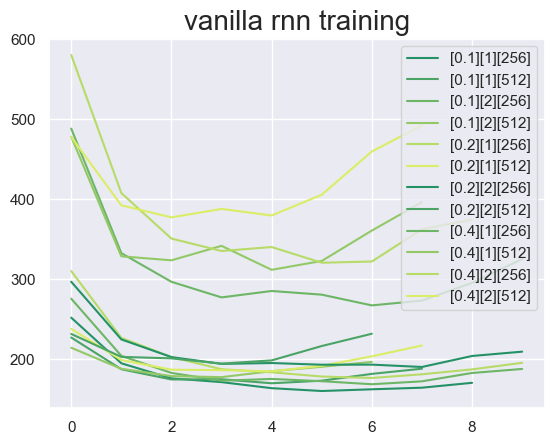

In [85]:
plt.title('vanilla rnn training', fontsize=20)
for ind1 in test_perplexity['rnn']:
    for ind2 in test_perplexity['rnn'][ind1]:
        for ind3 in test_perplexity['rnn'][ind1][ind2]:
            plt.plot(test_perplexity['rnn'][ind1][ind2][ind3], label='[%2.1f][%d][%d]' % (ind1, ind2, ind3))
            
plt.legend()
plt.show()

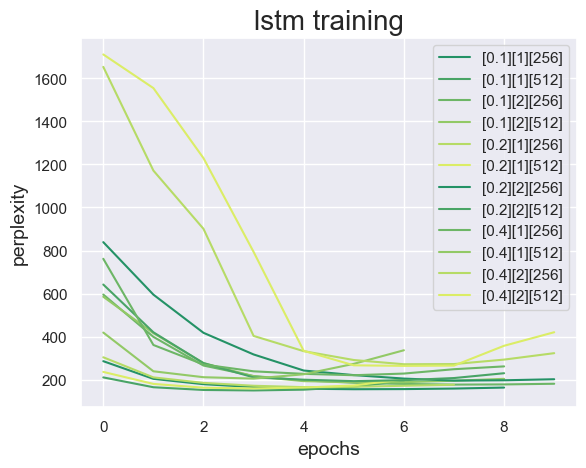

In [87]:
plt.title('lstm training', fontsize=20)
plt.xlabel('epochs', fontsize=14)
plt.ylabel('perplexity', fontsize=14)

for ind1 in test_perplexity['lstm']:
    for ind2 in test_perplexity['lstm'][ind1]:
        for ind3 in test_perplexity['lstm'][ind1][ind2]:
            plt.plot(test_perplexity['lstm'][ind1][ind2][ind3], label='[%2.1f][%d][%d]' % (ind1, ind2, ind3))

plt.legend()
plt.show()

По графикам видно, что все обучилось до сходимости

Теперь построим графики лучших результатов

In [98]:
def approx_y(x, y):
    p = np.polyfit(x, y, 1)
    return np.polyval(p, x)

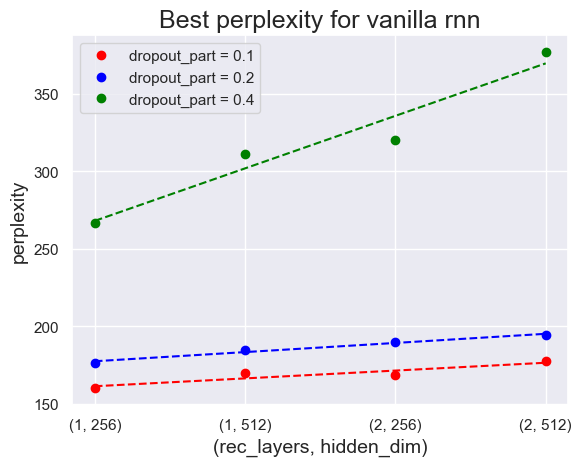

In [103]:
plt.title('Best perplexity for vanilla rnn', fontsize=18)
plt.xlabel('(rec_layers, hidden_dim)', fontsize=14)
plt.ylabel('perplexity', fontsize=14)
plt.xticks(range(4), ['(1, 256)', '(1, 512)', '(2, 256)', '(2, 512)'])
plt.plot(range(4), [159.9, 169.6, 168.3, 177.2], 'o', color = 'r', label = 'dropout_part = 0.1')
plt.plot(range(4), approx_y(range(4), [159.9, 169.6, 168.3, 177.2]), '--', color = 'r')

plt.plot(range(4), [176.2, 184.5, 189.9, 194.1], 'o', color = 'b', label = 'dropout_part = 0.2')
plt.plot(range(4), approx_y(range(4), [176.2, 184.5, 189.9, 194.1]), '--', color = 'b')

plt.plot(range(4), [266.9, 311.4, 320.3, 377], 'o', color = 'g', label = 'dropout_part = 0.4')
plt.plot(range(4), approx_y(range(4), [266.9, 311.4, 320.3, 377]), '--', color = 'g')
plt.legend()
plt.show()

Видно, что качество уменьшается при увеличении rec_layers, hidden_dim и dropout_part. 
Почему это происходит?
1.  С rec_layers все ясно: у нас и раньше было ухудшение качества при увеличении количества рекуррентных слоев из-за затухания градиента. 
Но есть еще один нюанс: так как мы берем не последний результат и считаем на нем градиент, а берем результаты с каждого момента времени, получается, что более ранние градиенты больше более поздних, из-за чего градиенты поздних слоев почти не учитываются. И отсюда получается забавный спецэффект, что у нас моделька учится начинать предложения, а заканчивать не особо учится. Понятно, что такой недостаток есть и у сети с 1 рекуррентным слоем, но тогда он не так сильно выражен.
2.  dropout_part, как уточнялось в прошлом дз имеет смысл делать больше, пока хватает оставшейся информации, чтобы получать валидный ответ. То есть у нас процесс обучения замедляется и средний лосс в процессе обучения поднимается, но если мы не выкинули слишком много информации, то в итоге мы получим лучший результат благодаря тому, что информация будет лучше структуризирована в слое. Увы, но в данном случае мы видим, что dropout_part мы не можем увеличивать.
3.  Интересно, что большой hidden_dim только делает хуже, хотя, казалось бы, чем больше можем запомнить информации, тем лучше. Ну как бы оно так, но это проявляется в том, что наша модель просто переобучается - падает в яму локального минимума, упираясь в свой предел из-за отсутствия глобальной памяти (то есть если бы была глобальная память, то модель выползла бы из ямы, пытаясь запомнить какие-то более глубокие взаимосвязи с контекстом, чтобы повысить общее качество, а наша модель на такое не способна). Вот бы жить в мире, где у нас есть глобальная память((((

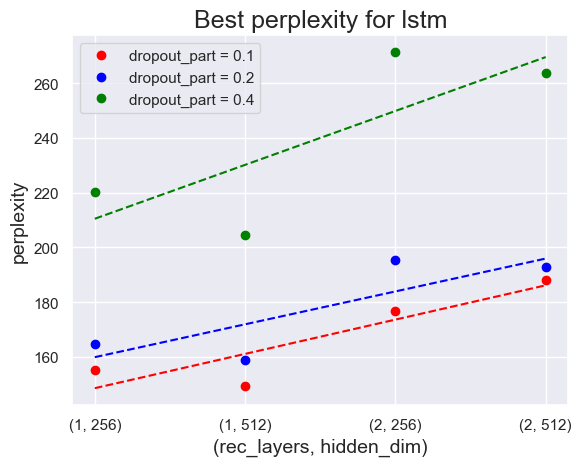

In [104]:
plt.title('Best perplexity for lstm', fontsize=18)
plt.xlabel('(rec_layers, hidden_dim)', fontsize=14)
plt.ylabel('perplexity', fontsize=14)
plt.xticks(range(4), ['(1, 256)', '(1, 512)', '(2, 256)', '(2, 512)'])
plt.plot(range(4), [155.2, 149.5, 176.7, 187.9], 'o', color = 'r', label = 'dropout_part = 0.1')
plt.plot(range(4), approx_y(range(4), [155.2, 149.5, 176.7, 187.9]), '--', color = 'r')

plt.plot(range(4), [164.8, 158.8, 195.2, 192.7], 'o', color = 'b', label = 'dropout_part = 0.2')
plt.plot(range(4), approx_y(range(4), [164.8, 158.8, 195.2, 192.7]), '--', color = 'b')

plt.plot(range(4), [220.3, 204.6, 271.3, 263.7], 'o', color = 'g', label = 'dropout_part = 0.4')
plt.plot(range(4), approx_y(range(4), [220.3, 204.6, 271.3, 263.7]), '--', color = 'g')
plt.legend()
plt.show()

Видно, что качество уменьшается при увеличении rec_layers и dropout_part, а при увеличении hidden_dim качество почти везде растет.
Почему это происходит?
1.  С rec_layers все аналогично: из-за дополнительного нюанса дополнительные рекуррентные слои и в lstm мешают, хотя, например, в предыдущем дз была немного другая картина.
2.  dropout_part, все аналогично.
3.  Мы переместились в мир с глобальной памятью, круто. В данном случае из-за глобального контекста нет локальной ямы, куда мы попали из-за переобучения в прошлый раз, так что мы можем повышать hidden_dim и радоваться жизни. 
Стоит отметить, что при [0.1][2][256] качество лучше, чем при [0.1][2][512]. Это, видимо, происходит из-за переобучения, так как 2 рекуррентных слоя, маленький dropoutи большой hidden_dim все же делают модель слишком мощной.

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

Заведем несколько модификаций нашей модели 3 линейными слоями вместо 1 и с batchnorm, batchnorm + dropout, dropout.

In [22]:
class LanguageModel_norm_3linear(nn.Module):
    def __init__(
            self, hidden_dim: int,
            vocab_size: int,
            dropout_part = 0.1,
            rec_layers = 1,
            rnn_type: str = 'rnn'
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)

        if rnn_type == 'rnn':
            self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True, num_layers=rec_layers)
        elif rnn_type == 'gru':
            self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True, num_layers=rec_layers)
        else: #'lstm'
            self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers=rec_layers)

        self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        self.norm1 = nn.BatchNorm1d(hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.norm2 = nn.BatchNorm1d(hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, hidden_dim)
        self.norm3 = nn.BatchNorm1d(hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        output = self.linear1(self.non_lin(output))  # [batch_size, seq_len, hidden_dim]
        output = output.permute(0, 2, 1)
        output = self.norm1(output)
        output = output.permute(0, 2, 1)

        output = self.linear2(self.non_lin(output))  # [batch_size, seq_len, hidden_dim]
        output = output.permute(0, 2, 1)
        output = self.norm2(output)
        output = output.permute(0, 2, 1)

        output = self.linear3(self.non_lin(output))  # [batch_size, seq_len, hidden_dim]
        output = output.permute(0, 2, 1)
        output = self.norm3(output)
        output = output.permute(0, 2, 1)

        prediction = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return prediction

In [23]:
class LanguageModel_dropout_3linear(nn.Module):
    def __init__(
            self, hidden_dim: int,
            vocab_size: int,
            dropout_part = 0.1,
            rec_layers = 1,
            rnn_type: str = 'rnn'
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)

        if rnn_type == 'rnn':
            self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True, num_layers=rec_layers)
        elif rnn_type == 'gru':
            self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True, num_layers=rec_layers)
        else: #'lstm'
            self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers=rec_layers)

        self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_part)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        output = self.dropout(self.linear1(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear2(self.non_lin(output)))
        output = self.dropout(self.linear3(self.non_lin(output)))

        prediction = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return prediction

In [24]:
class LanguageModel_dropout_norm_3linear(nn.Module):
    def __init__(
            self, hidden_dim: int,
            vocab_size: int,
            dropout_part = 0.1,
            rec_layers = 1,
            rnn_type: str = 'rnn'
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)

        if rnn_type == 'rnn':
            self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True, num_layers=rec_layers)
        elif rnn_type == 'gru':
            self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True, num_layers=rec_layers)
        else: #'lstm'
            self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers=rec_layers)

        self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        self.norm1 = nn.BatchNorm1d(hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.norm2 = nn.BatchNorm1d(hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, hidden_dim)
        self.norm3 = nn.BatchNorm1d(hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_part)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        output = self.linear1(self.non_lin(output))  # [batch_size, seq_len, hidden_dim]
        output = output.permute(0, 2, 1)
        output = self.norm1(output)
        output = self.dropout(output.permute(0, 2, 1))

        output = self.linear2(self.non_lin(output))  # [batch_size, seq_len, hidden_dim]
        output = output.permute(0, 2, 1)
        output = self.norm2(output)
        output = self.dropout(output.permute(0, 2, 1))

        output = self.linear3(self.non_lin(output))  # [batch_size, seq_len, hidden_dim]
        output = output.permute(0, 2, 1)
        output = self.norm3(output)
        output = self.dropout(output.permute(0, 2, 1))

        prediction = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return prediction

In [26]:
test_perplexity2 = {'rnn': {}, 'lstm': {}}

In [0]:
dropout_part = 0.1
rec_layers = 1

for rnn_type, hidden_dim in [('rnn', 256), ('lstm', 512)]:
    print('Start train %s with params: [\'%s\'][%f][%d][%d]' % ('LanguageModel_norm_3linear', rnn_type, dropout_part, rec_layers, hidden_dim))
    _, _, test_perplexity2[rnn_type]['norm'] = start_train(Model=LanguageModel_norm_3linear, rnn_type=rnn_type, dropout_part=dropout_part, rec_layers=rec_layers, hidden_dim=hidden_dim, epochs=10, print_logs=False)
    print("-----------------")
    print()
    print('Start train %s with params: [\'%s\'][%f][%d][%d]' % ('LanguageModel_dropout_3linear', rnn_type, dropout_part, rec_layers, hidden_dim))
    _, _, test_perplexity2[rnn_type]['dropout'] = start_train(Model = LanguageModel_dropout_3linear, rnn_type=rnn_type, dropout_part=dropout_part, rec_layers=rec_layers, hidden_dim=hidden_dim, epochs=10, print_logs=False)
    print("-----------------")
    print()
    print('Start train %s with params: [\'%s\'][%f][%d][%d]' % ('LanguageModel_dropout_norm_3linear', rnn_type, dropout_part, rec_layers, hidden_dim))
    _, _, test_perplexity2[rnn_type]['dropout_norm'] = start_train(Model = LanguageModel_dropout_norm_3linear, rnn_type=rnn_type, dropout_part=dropout_part, rec_layers=rec_layers, hidden_dim=hidden_dim, epochs=10, print_logs=False)
    print("-----------------")
    print()

Start train norm_3linear with params:  rnn 0.1 1 256
Best perplexity:  155.36431933206225
perplexities:  {'train': [942.6062149658203, 159.14888220214843, 123.79201416015626, 102.04056536865234, 87.27047726440429, 76.00518959045411, 66.86087162780761], 'val': [195.73671250116257, 168.06203388032458, 158.70779019310362, 155.36431933206225, 156.23794398232113, 159.59762549021886, 162.65148223392546]}
losses:  {'train': [5.790171792984009, 5.06263479423523, 4.81290719985962, 4.6205643405914305, 4.464815107345581, 4.326993738174439, 4.199111155509948], 'val': [tensor(5.1719, device='cuda:0'), tensor(5.0259, device='cuda:0'), tensor(4.9613, device='cuda:0'), tensor(4.9363, device='cuda:0'), tensor(4.9531, device='cuda:0'), tensor(4.9568, device='cuda:0'), tensor(4.9876, device='cuda:0')]}
-----------------

Start train dropout_3linear with params:  rnn 0.1 1 256
Best perplexity:  197.91681077745227
perplexities:  {'train': [1547.4459307861327, 299.11566278076174, 221.49654357910157, 185.801

In [105]:
test_perplexity2['rnn']['norm'] = [195.73671250116257, 168.06203388032458, 158.70779019310362, 155.36431933206225, 156.23794398232113, 159.59762549021886, 162.65148223392546]
test_perplexity2['rnn']['dropout'] = [394.4964081294953, 278.1130119202629, 241.19088066948785, 230.74022202264695, 222.55914451962425, 210.0740928044395, 203.0962168375651, 197.91681077745227, 202.58786349826389, 205.09300207713292]
test_perplexity2['rnn']['dropout_norm'] = [211.58504255991133, 184.03396461123512, 173.8324207124256, 168.47581130739243, 165.6800790211511, 167.29286399720206, 170.18177964952258, 175.39691428532677]
test_perplexity2['lstm']['norm'] = [160.16702972896516, 143.37693362765842, 146.86659373934307, 161.1595190139044, 188.7598126123822]
test_perplexity2['lstm']['dropout'] = [325.3058268229167, 249.41090441507006, 215.03563532753597, 200.08994377983942, 204.60326639811197, 206.75113690088665, 211.51207672603547]
test_perplexity2['lstm']['dropout_norm'] = [169.29813699873668, 151.13700539725167, 154.5105254158141, 173.07750677683995, 198.2212887718564]

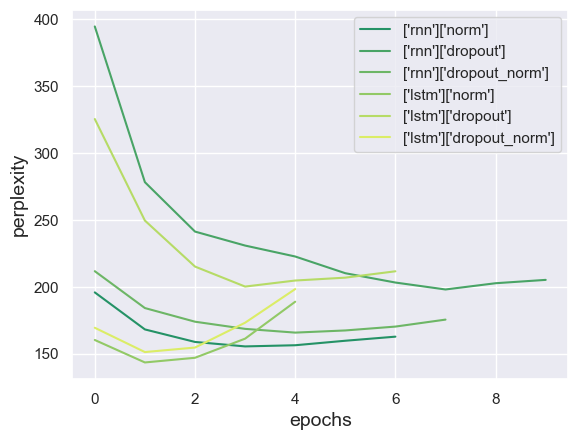

In [108]:
plt.xlabel('epochs', fontsize=14)
plt.ylabel('perplexity', fontsize=14)

for ind1 in test_perplexity2:
    for ind2 in test_perplexity2[ind1]:
        plt.plot(test_perplexity2[ind1][ind2], label='[\'%s\'][\'%s\']' % (ind1, ind2))

plt.legend()
plt.show()

Видно, что все тоже сошлось.

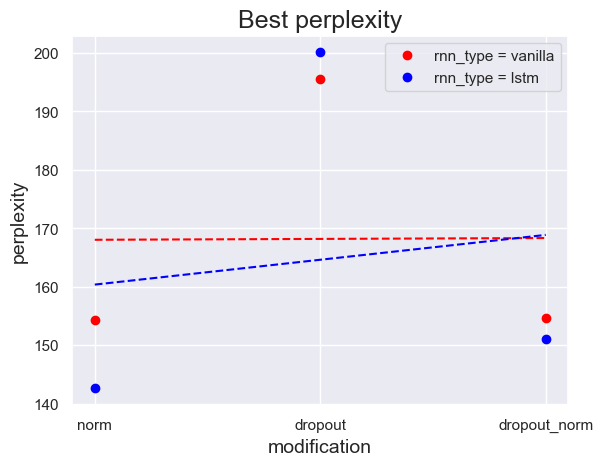

In [109]:
plt.title('Best perplexity', fontsize=18)
plt.xlabel('modification', fontsize=14)
plt.ylabel('perplexity', fontsize=14)
plt.xticks(range(3), ['norm', 'dropout', 'dropout_norm'])
plt.plot(range(3), [154.3, 195.6, 154.6], 'o', color = 'r', label = 'rnn_type = vanilla')
plt.plot(range(3), approx_y(range(3), [154.3, 195.6, 154.6]), '--', color = 'r')

plt.plot(range(3), [142.6, 200.1, 151.1], 'o', color = 'b', label = 'rnn_type = lstm')
plt.plot(range(3), approx_y(range(3), [142.6, 200.1, 151.1]), '--', color = 'b')

plt.legend()
plt.show()

Видим, что dropout только все портит, а с batchNorm качество немного получше. Видимо, это такая специфическая задача, что dropout здесь не применим, так как мы не можем себе позволить выбрасывать лишние данные.

### Обучение наилучшей модели и ее тестирование

In [25]:
#Берем все данные для достижения максимального качества
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

Наилучшая найденная модель это
 LanguageModel_norm_3linear(rnn_type='lstm', dropout_part=0.1, rec_layers=1, hidden_dim=512)

In [26]:
best_model, _, _ = start_train(Model = LanguageModel_norm_3linear, rnn_type='lstm', dropout_part=0.1, rec_layers=1, hidden_dim=512, epochs=20)

* Epoch 1/20
* Train  Epoch perplexity: 227.144695  Epoch loss: 4.994608
* Val    Epoch perplexity: 109.957289  Epoch loss: 4.622904
Saving best model...
* Epoch 2/20
* Train  Epoch perplexity: 88.012184  Epoch loss: 4.470177
* Val    Epoch perplexity: 100.290480  Epoch loss: 4.518374
Saving best model...
* Epoch 3/20
* Train  Epoch perplexity: 67.720672  Epoch loss: 4.210144
* Val    Epoch perplexity: 102.253615  Epoch loss: 4.537302
* Epoch 4/20
* Train  Epoch perplexity: 54.583666  Epoch loss: 3.995305
* Val    Epoch perplexity: 108.991089  Epoch loss: 4.599444
* Epoch 5/20
* Train  Epoch perplexity: 44.932413  Epoch loss: 3.801209
* Val    Epoch perplexity: 119.024839  Epoch loss: 4.687994

The model is trained
Best perplexity:  100.2904804944992
perplexities:  {'train': [227.1446949660778, 88.012183560431, 67.7206719815731, 54.58366558365524, 44.932412773557004], 'val': [109.9572889328003, 100.2904804944992, 102.25361506938934, 108.99108874797821, 119.0248391866684]}
losses:  {'tr

In [69]:
def generate_sequence(model, starting_seq: str, max_seq_len: int = 128) -> str:
    device = 'cpu'
    model = model.to(device)
    input_ids = [word2ind['<bos>']] + [
        word2ind.get(word, word2ind['<unk>']) for word in word_tokenize(starting_seq.lower())
    ]
    input_ids = torch.LongTensor([input_ids]).to(device)

    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            next_word_distribution = model(input_ids)[0, -1]
            next_word = next_word_distribution.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_word.unsqueeze(0).unsqueeze(0)], dim=1)

            if next_word.item() == word2ind['<eos>']:
                break

    sentence = ' '.join([ind2word[idx.item()] for idx in input_ids[0]])

    return sentence

Ну и потыкаемся в наши новейшие разработки.

In [75]:
generate_sequence(best_model, 'A lot of')

'<bos> a lot of the characters are all very good . <eos>'

In [76]:
generate_sequence(best_model, 'I love')

'<bos> i love the movie . <eos>'

In [77]:
generate_sequence(best_model, 'People hate')

"<bos> people hate it , but it 's a good movie . <eos>"

In [78]:
generate_sequence(best_model, 'I feel like')

'<bos> i feel like i was a kid . <eos>'

In [82]:
generate_sequence(best_model, 'I have amazing thought: ')

"<bos> i have amazing thought : `` i 'm a big fan of the original , but i 'm not sure what i 'm going to do . '' <eos>"

In [83]:
generate_sequence(best_model, 'I will be back')

"<bos> i will be back to the film 's first time and i have to say that i 'm not sure what i 'm going to see . <eos>"

Жаль, что наша модель обучена только на комментариях к фильмам, из-за чего ограничена в своих выражениях. Но все равно классно!!!

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

Описания всех экспериментов и их анализ с графиками идут вперемешку с проведением самих экспериментов для лучшей наглядности и сохранения последовательности повествования. Также такой подход позволяет отследить причинно-следственные связи принятия решений - какие эксперименты зачем проводились и как результаты одного эксперимента влияли на нашу модель и на последующие эксперименты.

Но если резюмировать, то вначале было настроено окружение для тестирования различных параметров модели, затем долгое тестирование параметров с анализом полученных результатов. Затем были взяты лучшие параметры и протестированы различные модификации архитектуры модели. После подбор финальных параметров и финальной архитектуры с последующим тестированием полученной модели. 